In [1]:
import spacy
import json
from spacy.lang.en.stop_words import STOP_WORDS
from string import punctuation
from collections import Counter
from heapq import nlargest
from spacy.matcher import Matcher
from spacy import displacy
from IPython.display import Image, display
import visualise_spacy_tree
from spacy.lang.en import English
import networkx as nx
import matplotlib.pyplot as plt
import re
from spacy.symbols import nsubj, VERB, ADJ
import pandas as pd
import numpy as np

In [2]:
!python -m spacy download en

  Using cached en_core_web_sm-2.3.1-py3-none-any.whl
✔ Download and installation successful
You can now load the model via spacy.load('en_core_web_sm')
✔ Linking successful
/Users/anmolbansal/opt/anaconda3/lib/python3.9/site-packages/en_core_web_sm -->
/Users/anmolbansal/opt/anaconda3/lib/python3.9/site-packages/spacy/data/en
You can now load the model via spacy.load('en')


In [3]:
nlp = spacy.load('en_core_web_sm')

In [4]:
def summarize(long_rev):
    summ = spacy.load('en_core_web_sm')
    long_rev = summ(long_rev)
    #print(f"Number of sentences : {len(list(long_rev.sents))}\n")

    keyword = []
    stopwords = list(STOP_WORDS)
    pos_tag = ['PROPN', 'ADJ', 'NOUN', 'VERB']
    for token in long_rev:
        if(token.text in stopwords or token.text in punctuation):
            continue
        if(token.pos_ in pos_tag):
            keyword.append(token.text)
    freq_word = Counter(keyword)
    #print("Filtering tokens \n")
    #print(freq_word.most_common(5))

    # Normalization
    # Each sentence is weighed based on the
    # frequency of the token present in each sentence

    #highest frequency
    max_freq = Counter(keyword).most_common(1)[0][1]
    
    #normalizing the frequency
    for word in freq_word.keys():
        freq_word[word] = (freq_word[word]/max_freq)
    freq_word.most_common(5)

    # Strength of sentences
    sent_strength = {}
    for sent in long_rev.sents:
        for word in sent:
            if word.text in freq_word.keys():
                if sent in sent_strength.keys():
                    sent_strength[sent] += freq_word[word.text]
                else:
                    sent_strength[sent] = freq_word[word.text]
    #print("sentences with their respective strengths \n")
    #print(sent_strength)

# the nlargest function returns a list containing the top 3 sentences which are stored as summarized_sentences

    summarized_sentences = nlargest(3, sent_strength, key=sent_strength.get)
    #print("top 3 sentences with max strength ")
    #print(summarized_sentences, "\n")

    #print("Final Summarized Review ")
    final_sentences = [w.text for w in summarized_sentences]
    summary = ' '.join(final_sentences)
    
    return summary


The Honda City is a well balanced car with an amazing engine to drive. It runs very smoothly and rarely breaks down


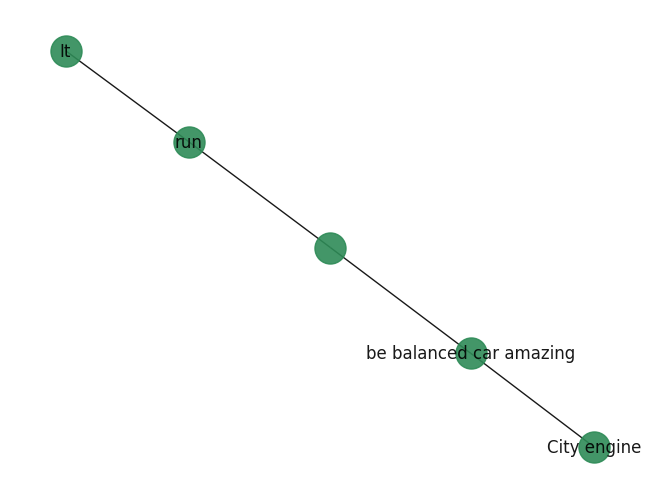

In [5]:
def getSentences(text):
    nlp = English()
    nlp.add_pipe('sentencizer')
    document = nlp(text)
    return [sent.text.strip() for sent in document.sents]


def printToken(token):
    print(token.text, "->", token.dep_)


def appendChunk(original, chunk):
    return original + ' ' + chunk


def isRelationCandidate(token):
    deps = ["ROOT", "adj", "attr", "agent", "amod"]
    return any(subs in token.dep_ for subs in deps)


def isConstructionCandidate(token):
    deps = ["compound", "prep", "conj", "mod"]
    return any(subs in token.dep_ for subs in deps)


def processSubjectObjectPairs(tokens):
    subject = ''
    object = ''
    relation = ''
    subjectConstruction = ''
    objectConstruction = ''
    for token in tokens:
        #printToken(token)
        if "punct" in token.dep_:
            continue
        if isRelationCandidate(token):
            relation = appendChunk(relation, token.lemma_)
        if isConstructionCandidate(token):
            if subjectConstruction:
                subjectConstruction = appendChunk(
                    subjectConstruction, token.text)
            if objectConstruction:
                objectConstruction = appendChunk(
                    objectConstruction, token.text)
        if "subj" in token.dep_:
            subject = appendChunk(subject, token.text)
            subject = appendChunk(subjectConstruction, subject)
            subjectConstruction = ''
        if "obj" in token.dep_:
            object = appendChunk(object, token.text)
            object = appendChunk(objectConstruction, object)
            objectConstruction = ''

    #print(subject.strip(), ",", relation.strip(), ",", object.strip())
    return (subject.strip(), relation.strip(), object.strip())


def processSentence(sentence):
    tokens = nlp(sentence)
    return processSubjectObjectPairs(tokens)


def printGraph(triples):
    G = nx.Graph()
    for triple in triples:
        G.add_node(triple[0])
        G.add_node(triple[1])
        G.add_node(triple[2])
        G.add_edge(triple[0], triple[1])
        G.add_edge(triple[1], triple[2])

    pos = nx.spring_layout(G)
    plt.figure()
    nx.draw(G, pos, edge_color='black', width=1, linewidths=1,
            node_size=500, node_color='seagreen', alpha=0.9,
            labels={node: node for node in G.nodes()})
    plt.axis('off')
    plt.show()


def knowledge_graph(text):
  sentences = getSentences(text)
  nlp_model = spacy.load('en_core_web_sm')
  triples = []
  print(text)
  for sentence in sentences:
      triples.append(processSentence(sentence))

  printGraph(triples)


text = "The Honda City is a well balanced car with an amazing engine to drive. It runs very smoothly and rarely breaks down"

knowledge_graph(text)

In [6]:
def IE_Operations(review):
    # create spacy doc
    doc = nlp(review)
    adjectives = set()
    verbs_all = set()
    # applying POS to each token
    '''print("POS Tagging : ")
    for token in doc:
        if token.pos_ not in ["SPACE", "DET", "ADP", "PUNCT", "AUX", "SCONJ", "CCONJ", "PART"]:
            print(token.text, '->', token.pos_)
        if(token.pos_ == "ADJ"):
            adjectives.add(token.text)
        if(token.pos_ == "VERB"):
            verbs_all.add(token.text)'''

    print("Dependency Graph : \n")

    print("************************************************************\n")
    displacy.render(doc, style='dep', jupyter=True)
    print("************************************************************\n")

    '''print("Verb with subject : \n")

    # Finding a verb with a subject
    verbs = set()
    for possible_subject in doc:
        if possible_subject.dep == nsubj and possible_subject.head.pos == VERB:
            verbs.add(possible_subject.head)
    print(verbs)
    print("************************************************************\n")

    print("Adjectives : \n")

    # Finding adjectives with a subject
    print(adjectives)
    print("************************************************************\n")
    # NER
    for ent in doc.ents:
        print(ent.text, ent.start_char, ent.end_char, ent.label_)
    print("************************************************************\n")'''

    print("Knowledge Graph : \n")

    knowledge_graph(review)

    print("************************************************************\n")


In [7]:
# function to preprocess speech

def clean(text):

    # removing paragraph numbers
    text = re.sub('[0-9]+.\t', '', str(text))
    # removing new line characters
    text = re.sub('\n ', '', str(text))
    text = re.sub('\n', ' ', str(text))
    # removing apostrophes
    text = re.sub("'s", '', str(text))
    # removing hyphens
    text = re.sub("-", ' ', str(text))
    text = re.sub("— ", '', str(text))
    # removing quotation marks
    text = re.sub('\"', '', str(text))
    # removing salutations
    text = re.sub("Mr\.", 'Mr', str(text))
    text = re.sub("Mrs\.", 'Mrs', str(text))
    # removing any reference to outside text
    text = re.sub("[\(\[].*?[\)\]]", "", str(text))
    text = text.replace("\r", "")

    return text

In [8]:
df = pd.read_csv('./Dataset/Scraped_Car_Review_dodge.csv',
                 delimiter=',', nrows=100)
df.head()

,Unnamed: 0,Review_Date,Author_Name,Vehicle_Title,Review_Title,Review,Rating
0,0,on 10/13/05 15:30 PM (PDT),roadking,2002 Dodge Ram Cargo Van 1500 3dr Van (3.9L 6c...,Great delivery vehicle,It's been a great delivery vehicle for my caf...,4.625
1,1,on 07/17/05 21:59 PM (PDT),Mark,2002 Dodge Ram Cargo Van 3500 3dr Ext Van (5.2...,Disappointmnet,Bought this car as a commuter vehicle for a v...,2.125
2,2,on 07/16/02 00:00 AM (PDT),Tom Sheer,2002 Dodge Ram Cargo Van 3500 Maxi 3dr Ext Van...,Sweet van,"This van rocks its the best, lots of \rroom. ...",5.000
3,3,on 12/29/07 21:57 PM (PST),Keven Smith,2001 Dodge Ram Cargo Van 2500 Maxi 3dr Ext Van...,Keven Smith,Great work vehicle. Drives nice. has lots of ...,4.500
4,4,on 02/09/05 18:52 PM (PST),VanMan,2001 Dodge Ram Cargo Van 1500 3dr Van (3.9L 6c...,Not what Dodge used to be,Good solid frame and suspension. Well equipp...,2.875


In [9]:
# preprocessing speeches
df['Review_clean'] = df['Review'].apply(clean)

In [10]:
df.head()

,Unnamed: 0,Review_Date,Author_Name,Vehicle_Title,Review_Title,Review,Rating,Review_clean
0,0,on 10/13/05 15:30 PM (PDT),roadking,2002 Dodge Ram Cargo Van 1500 3dr Van (3.9L 6c...,Great delivery vehicle,It's been a great delivery vehicle for my caf...,4.625,It been a great delivery vehicle for my cafe ...
1,1,on 07/17/05 21:59 PM (PDT),Mark,2002 Dodge Ram Cargo Van 3500 3dr Ext Van (5.2...,Disappointmnet,Bought this car as a commuter vehicle for a v...,2.125,Bought this car as a commuter vehicle for a v...
2,2,on 07/16/02 00:00 AM (PDT),Tom Sheer,2002 Dodge Ram Cargo Van 3500 Maxi 3dr Ext Van...,Sweet van,"This van rocks its the best, lots of \rroom. ...",5.000,"This van rocks its the best, lots of room. I ..."
3,3,on 12/29/07 21:57 PM (PST),Keven Smith,2001 Dodge Ram Cargo Van 2500 Maxi 3dr Ext Van...,Keven Smith,Great work vehicle. Drives nice. has lots of ...,4.500,Great work vehicle. Drives nice. has lots of ...
4,4,on 02/09/05 18:52 PM (PST),VanMan,2001 Dodge Ram Cargo Van 1500 3dr Van (3.9L 6c...,Not what Dodge used to be,Good solid frame and suspension. Well equipp...,2.875,Good solid frame and suspension. Well equipp...


In [11]:
df['Review_clean'][2]

' This van rocks its the best, lots of room. I carry a lot of cargo in mine and i tow a lot too, it works great!'

In [12]:
reviews = df['Review_clean'][0:10]
reviews = np.array(reviews)
reviews[8]

' This is a left over new van. Great deal '

Dependency Graph : 

************************************************************



************************************************************

Knowledge Graph : 

 It been a great delivery vehicle for my cafe business good power, economy match easily taken care of. Havent repaired anything or replaced anything but tires and normal maintenance items. Upgraded tires to Michelin LX series helped fuel economy. Would buy another in a second


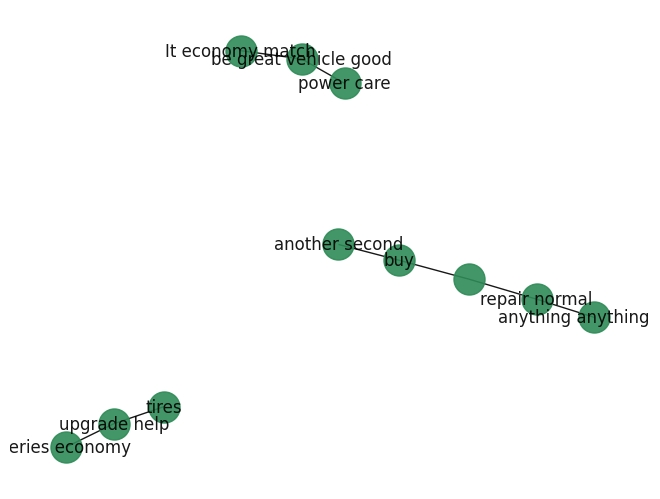

************************************************************



In [13]:
# applying POS tagging to each review in the dataset and preparing dependency graph, knowledge graph
# and filtering out verbs and pronouns to apply sentiment analysis as well
IE_Operations(reviews[0])

In [14]:
from statistics import mean


def IE_brand(brand):
    path = "./Dataset/Scraped_Car_Review_" + brand + ".csv"
    df = pd.read_csv(path, delimiter=',', nrows=100).sort_values(by = 'Rating', ascending = False)
    df['Review_clean'] = df['Review'].apply(clean)
    #df['Review_clean'][2]
    reviews = df['Review_clean'][0:5]
    reviews = list(reviews)
    print("TOP 5 REVIEWS FOR THE BRAND {} ARE:".format(brand.upper()))
    for i in range(0, 5):
        print("{}. {}".format(i+1, reviews[i]))
    review = ' '.join(reviews)
    mean = df["Rating"].mean()
    sum = summarize(review)
    print("\nSUMMARY REVIEW FOR THE {}: \n". format(brand.upper()))
    print(sum, '\n')
    IE_Operations(sum)
    print("MEAN SENTIMENT ASSOCIATED WITH THE BRAND {} : {}!".format(brand.upper(), mean))


TOP 5 REVIEWS FOR THE BRAND FERRARI ARE:
1.  This car gets great gas mileage and is the best car you could buy.
2.  No imitator here.   Purchased this car for the Speed, Comfort, and CLASS.   Waited nearly Two years, but honestly worth it.    Bentley, Aston, Lambo, no longer carry this type of Ferrari substance, nor its price tag.    Extremely satisfied with this 4.0  0 60 large, safe, comfortable sports car.    Truly in a world of its own. 
3.  i love it
4.  I like this car.
5.  Th is car is a great car to own.  Great when you have money for this, I enjoy riding in mine everyday when I head out to work.

SUMMARY REVIEW FOR THE FERRARI: 

 This car gets great gas mileage and is the best car you could buy.  Th is car is a great car to own.    Extremely satisfied with this 4.0  0 60 large, safe, comfortable sports car. 

Dependency Graph : 

************************************************************



************************************************************

Knowledge Graph : 

 This car gets great gas mileage and is the best car you could buy.  Th is car is a great car to own.    Extremely satisfied with this 4.0  0 60 large, safe, comfortable sports car.


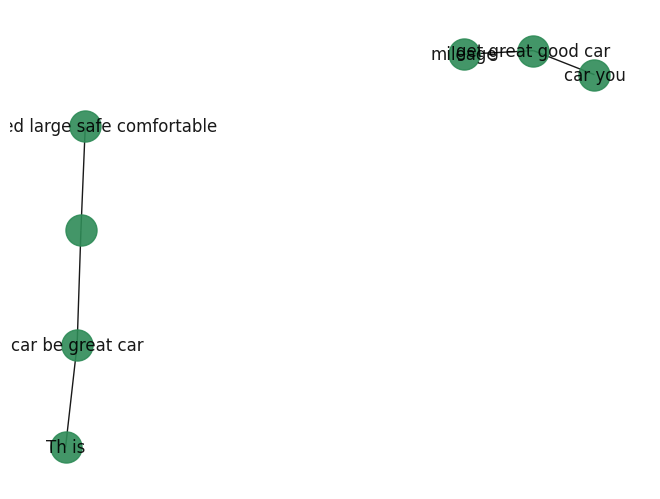

************************************************************

MEAN SENTIMENT ASSOCIATED WITH THE BRAND FERRARI : 4.722727272727273!


In [15]:
IE_brand("ferrari")